# Machine Learning Project 2 (Neural Networks)

In [38]:
# Imports
import os
import random
import time
import shutil
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

## Data Understanding

### Analyse Class Distribution

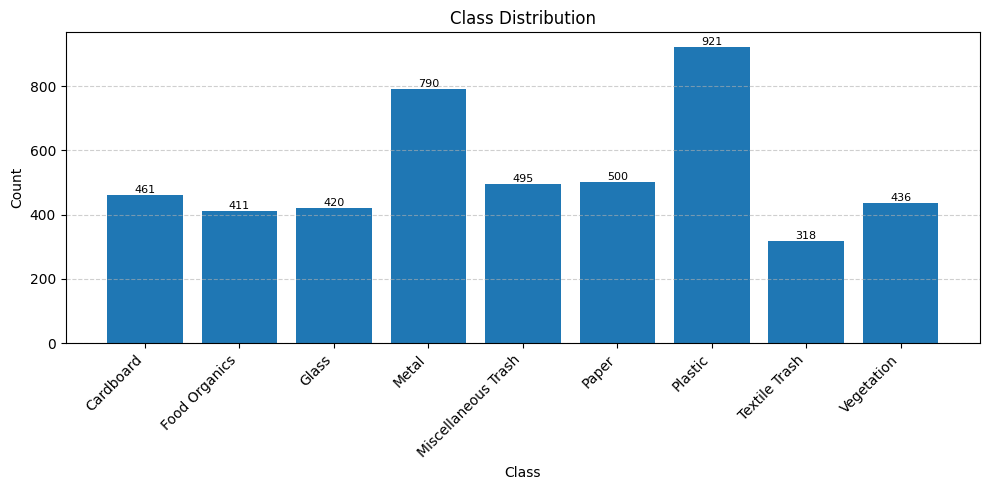

In [6]:
# Dataset path
dataset_path = Path("RealWaste")

# Count images per class
class_counts = {}
for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        num_images = len([f for f in class_dir.iterdir() if f.is_file()])
        class_counts[class_dir.name] = num_images

# Plot bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Image Samples

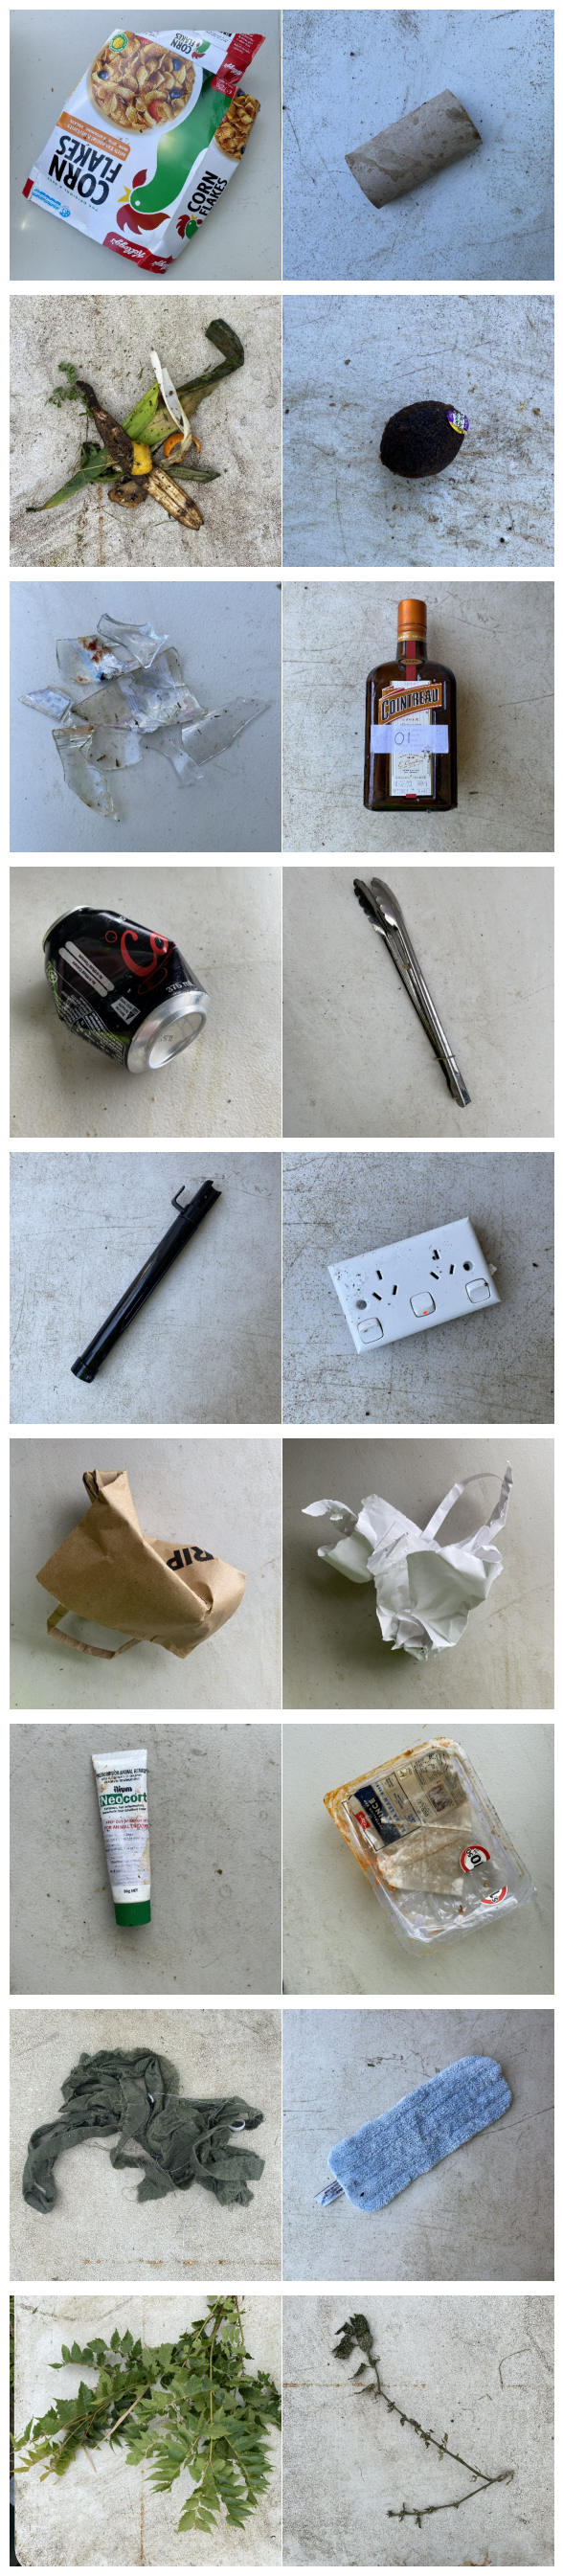

In [7]:
# Number of examples per class
examples_per_class = 2

# Collect example images
examples = {}

for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        image_files = list(class_dir.glob("*"))
        selected = random.sample(image_files, min(len(image_files), examples_per_class))
        examples[class_dir.name] = selected

# Plot examples
num_classes = len(examples)
plt.figure(figsize=(examples_per_class * 3, num_classes * 3))

for row_idx, (class_name, image_paths) in enumerate(examples.items()):
    for col_idx, img_path in enumerate(image_paths):
        idx = row_idx * examples_per_class + col_idx + 1
        img = Image.open(img_path)
        plt.subplot(num_classes, examples_per_class, idx)
        plt.imshow(img)
        plt.axis('off')
        if col_idx == 0:
            plt.ylabel(class_name, fontsize=10)

plt.tight_layout()
plt.show()

### Check Image sizes

In [8]:
# Collect image sizes
image_sizes = []

for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.glob("*"):
            img = Image.open(img_path)
            image_sizes.append(img.size)  # (width, height)

# Count sizes
size_counts = Counter(image_sizes)

# Print size frequencies
for size, count in size_counts.most_common():
    print(f"Size {size}: {count} images")

Size (524, 524): 4752 images


## Data Preparation

### Train / Val / Test Split (X, 50, 50)

In [9]:
# Fix random seed
random.seed(42)

# Define paths and split sizes
root_dir = Path("RealWaste")
output_dir = Path("RealWaste_splitted")
val_count = 50
test_count = 50

# Get class names
classes = [d.name for d in root_dir.iterdir() if d.is_dir()]

# Process each class
for cls in classes:
    cls_path = root_dir / cls
    images = list(cls_path.glob('*'))
    total = len(images)
    random.shuffle(images)

    # Split into val, test, and train
    val_imgs = images[:val_count]
    test_imgs = images[val_count:val_count + test_count]
    train_imgs = images[val_count + test_count:]

    splits = {
        'train': train_imgs,
        'val': val_imgs,
        'test': test_imgs
    }

    # Copy files to new structure
    for split, imgs in splits.items():
        split_dir = output_dir / split / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        for img in imgs:
            shutil.copy(img, split_dir / img.name)

### Analyse Class / Split Distribution

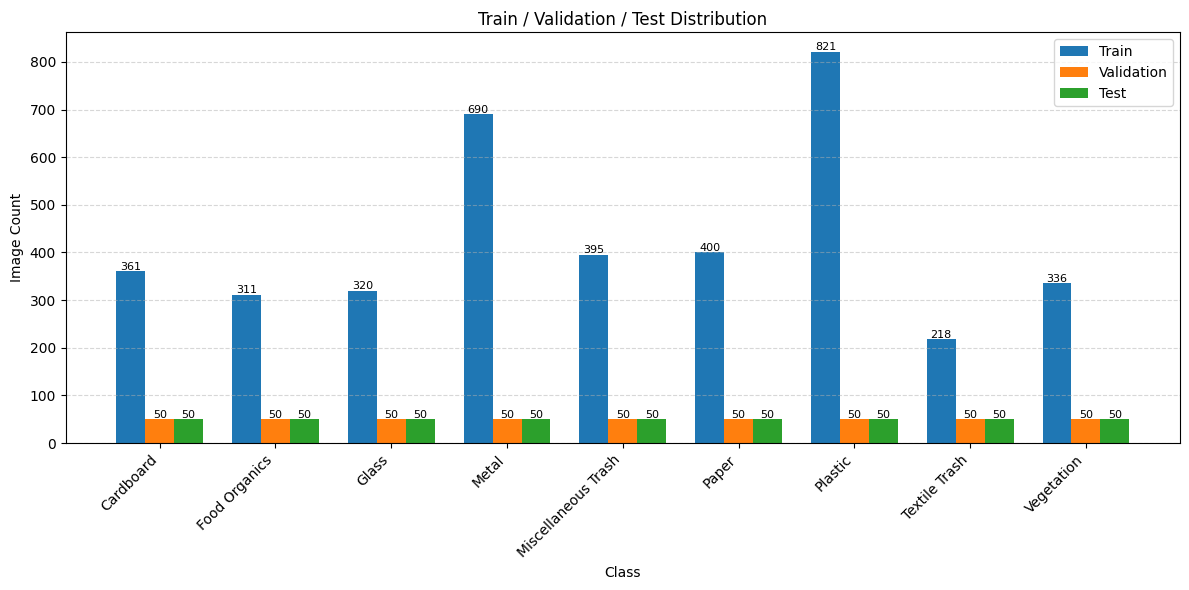

In [10]:
# Count images per class in each split
split_counts = {"train": {}, "val": {}, "test": {}}

for split in split_counts:
    split_path = os.path.join("RealWaste_splitted", split)
    if not os.path.exists(split_path):
        continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            split_counts[split][cls] = len([
                f for f in os.listdir(cls_path)
                if os.path.isfile(os.path.join(cls_path, f))
            ])

# Get sorted class names
all_classes = sorted(set(k for split in split_counts.values() for k in split))

# Extract counts
train_vals = [split_counts['train'].get(cls, 0) for cls in all_classes]
val_vals = [split_counts['val'].get(cls, 0) for cls in all_classes]
test_vals = [split_counts['test'].get(cls, 0) for cls in all_classes]

# Plot grouped bar chart
x = range(len(all_classes))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Train')
plt.bar(x, val_vals, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_vals, width=bar_width, label='Test')

# Add counts above bars
for i in x:
    plt.text(i - bar_width, train_vals[i] + 3, str(train_vals[i]), ha='center', fontsize=8)
    plt.text(i, val_vals[i] + 3, str(val_vals[i]), ha='center', fontsize=8)
    plt.text(i + bar_width, test_vals[i] + 3, str(test_vals[i]), ha='center', fontsize=8)

plt.xticks(x, all_classes, rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Train / Validation / Test Distribution")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Transform Data

In [11]:
# Transform for training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 128x128
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontally
    transforms.RandomRotation(degrees=15),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02), # Random brightness
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize per channel
                         std=[0.229, 0.224, 0.225])
])

# Transform for validation and test 
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Load Data and Balance Training Data with WeightedRandomSampler

In [12]:
# Load datasets with transforms
train_data = ImageFolder(root="RealWaste_splitted/train", transform=train_transform)
val_data = ImageFolder(root="RealWaste_splitted/val", transform=val_test_transform)
test_data = ImageFolder(root="RealWaste_splitted/test", transform=val_test_transform)

# Get class labels
targets = [label for _, label in train_data.samples]

# Count samples per class
class_counts = Counter(targets)
num_samples = len(train_data)

# Compute weights
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# Create sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create loaders
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Modeling

### Initialize Model

In [13]:
class WasteCNN(nn.Module):
    def __init__(self, conv_filters, fc_neurons, dropout_rate, use_batchnorm, num_classes):
        super(WasteCNN, self).__init__()

        # 3 conv layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, conv_filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_filters[0]) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_filters[1]) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_filters[2]) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # fc layer
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_filters[2] * 16 * 16, fc_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_neurons, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Search Space for Random Search

In [76]:
# Search space
search_params = {
    "lr": lambda: 10 ** random.uniform(-4, -2),
    "dropout": lambda: random.uniform(0.1, 0.5),
    "conv_filters": lambda: random.choice([
        (16, 32, 64),
        (32, 64, 128)
    ]),
    "fc_neurons": lambda: random.choice([128, 256]),
    "use_batchnorm": lambda: random.choice([True, False])
}

### Random Search

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Fixed
num_classes = 9
num_epochs = 10

# Log all results
all_logs = []

# Start search
for run in range(10):
    start_time = time.time()

    # Sample config
    config = {k: v() for k, v in search_params.items()}
    lr = config["lr"]
    dropout = config["dropout"]
    convs = config["conv_filters"]
    fc = config["fc_neurons"]
    bn = config["use_batchnorm"]

    model = WasteCNN(
        conv_filters=convs,
        fc_neurons=fc,
        dropout_rate=dropout,
        use_batchnorm=bn,
        num_classes=num_classes
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        running_loss = 0.0
        total_batches = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_batches += 1

        avg_train_loss = running_loss / total_batches

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total

        # Save epoch result
        all_logs.append({
            "run": run + 1,
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_acc": val_acc,
            "lr": lr,
            "dropout": dropout,
            "conv_filters": convs,
            "fc_neurons": fc,
            "batchnorm": bn
        })

    duration = time.time() - start_time
    print(f"Run {run+1}/10 done in {duration:.1f}s")

# Convert to DataFrame
df = pd.DataFrame(all_logs)

# Show full log
pd.set_option('display.max_rows', None)
print(df)

# save to df
df.to_csv("random_search_results.csv", index=False)

Run 1/10 done in 413.2s
Run 2/10 done in 547.5s
Run 3/10 done in 572.9s
Run 4/10 done in 665.8s
Run 5/10 done in 420.5s
Run 6/10 done in 557.8s
Run 7/10 done in 373.1s
Run 8/10 done in 368.9s
Run 9/10 done in 414.3s
Run 10/10 done in 577.8s
    run  epoch  train_loss    val_acc        lr   dropout   conv_filters  \
0     1      1    2.083413  35.333333  0.005058  0.365342   (16, 32, 64)   
1     1      2    1.728330  33.777778  0.005058  0.365342   (16, 32, 64)   
2     1      3    1.630114  42.222222  0.005058  0.365342   (16, 32, 64)   
3     1      4    1.521567  48.666667  0.005058  0.365342   (16, 32, 64)   
4     1      5    1.461080  45.111111  0.005058  0.365342   (16, 32, 64)   
5     1      6    1.343336  52.000000  0.005058  0.365342   (16, 32, 64)   
6     1      7    1.323288  55.555556  0.005058  0.365342   (16, 32, 64)   
7     1      8    1.349405  54.222222  0.005058  0.365342   (16, 32, 64)   
8     1      9    1.268101  56.222222  0.005058  0.365342   (16, 32, 64)   

### Find Best Configuration

In [79]:
df = pd.read_csv("random_search_results.csv")

# find best row (combination and epoch)
best_row = df.sort_values(by="val_acc", ascending=False).iloc[0]
print(best_row)

run                         6
epoch                      10
train_loss           0.876296
val_acc             67.777778
lr                   0.000679
dropout                0.3363
conv_filters    (32, 64, 128)
fc_neurons                128
batchnorm               False
Name: 59, dtype: object


### Try Best Configuration with more Epochs

In [18]:
# final configuration
model = WasteCNN(
    conv_filters=(32, 64, 128),
    fc_neurons=128,
    dropout_rate=0.3363,
    use_batchnorm=False,
    num_classes=9
).to(device)

In [19]:
max_epochs = 50
patience = 5
best_val_acc = 0
epochs_no_improve = 0

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000679)

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0
    total_batches = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

    avg_train_loss = running_loss / total_batches

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Epoch {epoch}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

model.load_state_dict(best_model_wts)
print(f"Final model restored with best Val Acc: {best_val_acc:.2f}%")

Epoch 1/50 | Train Loss: 1.9116 | Val Acc: 39.56%
Epoch 2/50 | Train Loss: 1.5531 | Val Acc: 47.11%
Epoch 3/50 | Train Loss: 1.3767 | Val Acc: 55.11%
Epoch 4/50 | Train Loss: 1.2767 | Val Acc: 54.67%
Epoch 5/50 | Train Loss: 1.1923 | Val Acc: 55.56%
Epoch 6/50 | Train Loss: 1.0681 | Val Acc: 57.33%
Epoch 7/50 | Train Loss: 1.0497 | Val Acc: 66.00%
Epoch 8/50 | Train Loss: 0.9896 | Val Acc: 63.33%
Epoch 9/50 | Train Loss: 0.9719 | Val Acc: 64.22%
Epoch 10/50 | Train Loss: 0.9000 | Val Acc: 66.89%
Epoch 11/50 | Train Loss: 0.8339 | Val Acc: 65.33%
Epoch 12/50 | Train Loss: 0.7870 | Val Acc: 68.44%
Epoch 13/50 | Train Loss: 0.7438 | Val Acc: 61.56%
Epoch 14/50 | Train Loss: 0.7473 | Val Acc: 69.33%
Epoch 15/50 | Train Loss: 0.7300 | Val Acc: 71.11%
Epoch 16/50 | Train Loss: 0.6931 | Val Acc: 70.44%
Epoch 17/50 | Train Loss: 0.6537 | Val Acc: 71.33%
Epoch 18/50 | Train Loss: 0.6084 | Val Acc: 71.11%
Epoch 19/50 | Train Loss: 0.5900 | Val Acc: 72.67%
Epoch 20/50 | Train Loss: 0.5767 | Val A

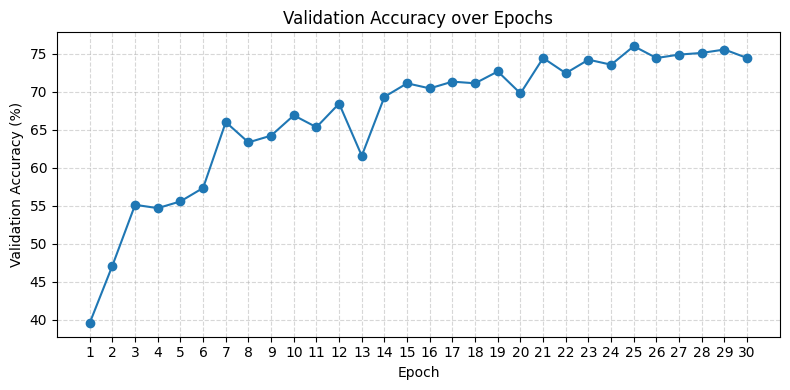

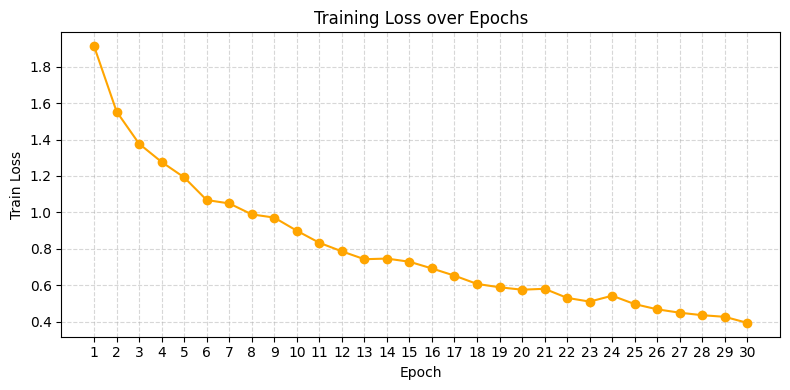

In [ ]:
# load csv
df = pd.read_csv("best_model.csv")

# plot validation acc
plt.figure(figsize=(8, 4))
plt.plot(df["epoch"], df["val_acc"], marker="o", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(df["epoch"])
plt.tight_layout()
plt.show()

# plot training loss
plt.figure(figsize=(8, 4))
plt.plot(df["epoch"], df["train_loss"], marker="o", color="orange", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(df["epoch"])
plt.tight_layout()
plt.show()

## Evaluation

### Tuned CNN Performance 

                     precision    recall  f1-score   support

          Cardboard       0.84      0.84      0.84        50
      Food Organics       0.87      0.92      0.89        50
              Glass       0.95      0.72      0.82        50
              Metal       0.68      0.64      0.66        50
Miscellaneous Trash       0.69      0.62      0.65        50
              Paper       0.80      0.82      0.81        50
            Plastic       0.73      0.72      0.73        50
      Textile Trash       0.70      0.88      0.78        50
         Vegetation       0.87      0.94      0.90        50

           accuracy                           0.79       450
          macro avg       0.79      0.79      0.79       450
       weighted avg       0.79      0.79      0.79       450



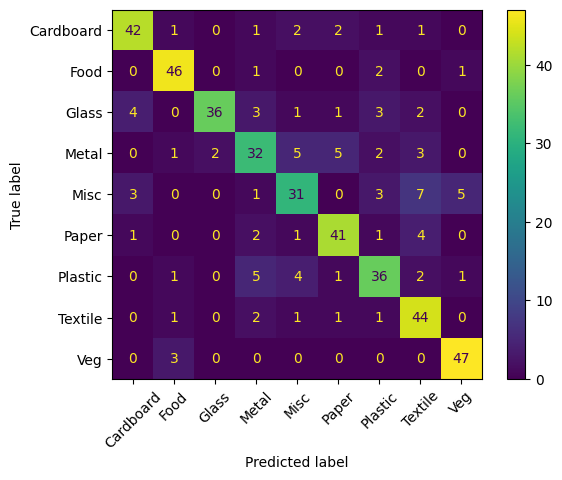

In [34]:
# Set model to eval mode
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

# Inference loop (no gradients)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification metrics
report = classification_report(all_labels, all_preds, target_names=test_data.classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cardboard", "Food", "Glass", "Metal", "Misc", "Paper", "Plastic", "Textile", "Veg"])
disp.plot(xticks_rotation=45)
plt.show()

### Dummy Classifier

                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        50
      Food Organics       0.00      0.00      0.00        50
              Glass       0.00      0.00      0.00        50
              Metal       0.00      0.00      0.00        50
Miscellaneous Trash       0.00      0.00      0.00        50
              Paper       0.00      0.00      0.00        50
            Plastic       0.11      1.00      0.20        50
      Textile Trash       0.00      0.00      0.00        50
         Vegetation       0.00      0.00      0.00        50

           accuracy                           0.11       450
          macro avg       0.01      0.11      0.02       450
       weighted avg       0.01      0.11      0.02       450



c:\Users\nikob\Desktop\ML_Project_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nikob\Desktop\ML_Project_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nikob\Desktop\ML_Project_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

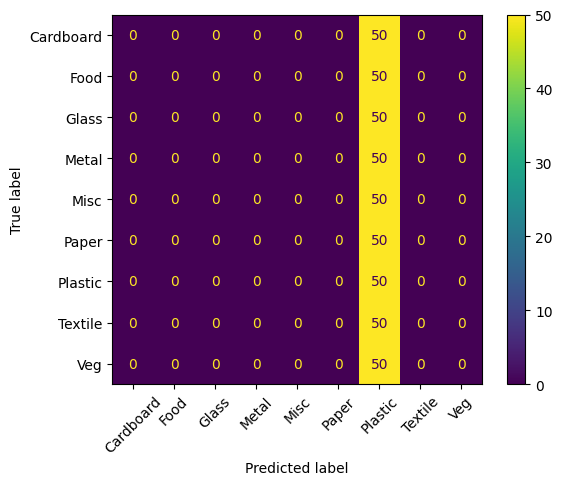

In [33]:
# Extract labels
raw_train = ImageFolder("RealWaste_splitted/train")
raw_test = ImageFolder("RealWaste_splitted/test")

# Read labels
train_labels = [label for _, label in raw_train]
test_labels = [label for _, label in raw_test]

# Train 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(np.zeros(len(train_labels)).reshape(-1, 1), train_labels)

# Predict
preds = dummy.predict(np.zeros(len(test_labels)).reshape(-1, 1))

# Classification Report
print(classification_report(test_labels, preds, target_names=raw_test.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cardboard", "Food", "Glass", "Metal", "Misc", "Paper", "Plastic", "Textile", "Veg"])
disp.plot(xticks_rotation=45)
plt.show()